In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Mars.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88393 entries, 0 to 88392
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date (TDB)  88393 non-null  object 
 1   X (km)      88393 non-null  float64
 2   Y (km)      88393 non-null  float64
 3   Z (km)      88393 non-null  float64
 4   VX (km/s)   88393 non-null  float64
 5   VY (km/s)   88393 non-null  float64
 6   VZ (km/s)   88393 non-null  float64
dtypes: float64(6), object(1)
memory usage: 4.7+ MB


In [22]:
df['Date (TDB)'] = pd.to_datetime(df['Date (TDB)'])
df.columns = df.columns.str.strip() 
df

,Date (TDB),X (km),Y (km),Z (km),VX (km/s),VY (km/s),VZ (km/s)
0,2015-03-05 00:00:00,1.899863e+08,9.812135e+07,-2.615628e+06,-10.210942,23.593563,0.744773
1,2015-03-05 01:00:00,1.899496e+08,9.820628e+07,-2.612947e+06,-10.220250,23.588738,0.744901
2,2015-03-05 02:00:00,1.899128e+08,9.829119e+07,-2.610265e+06,-10.229555,23.583910,0.745028
3,2015-03-05 03:00:00,1.898759e+08,9.837608e+07,-2.607582e+06,-10.238857,23.579078,0.745155
4,2015-03-05 04:00:00,1.898390e+08,9.846096e+07,-2.604900e+06,-10.248157,23.574242,0.745282
...,...,...,...,...,...,...,...
88388,2025-04-03 20:00:00,-2.173507e+08,1.220290e+08,7.910175e+06,-11.029039,-19.012406,-0.127785
88389,2025-04-03 21:00:00,-2.173904e+08,1.219605e+08,7.909715e+06,-11.022344,-19.016199,-0.128028
88390,2025-04-03 22:00:00,-2.174301e+08,1.218920e+08,7.909254e+06,-11.015648,-19.019990,-0.128272
88391,2025-04-03 23:00:00,-2.174697e+08,1.218236e+08,7.908791e+06,-11.008951,-19.023780,-0.128516


<Axes: >

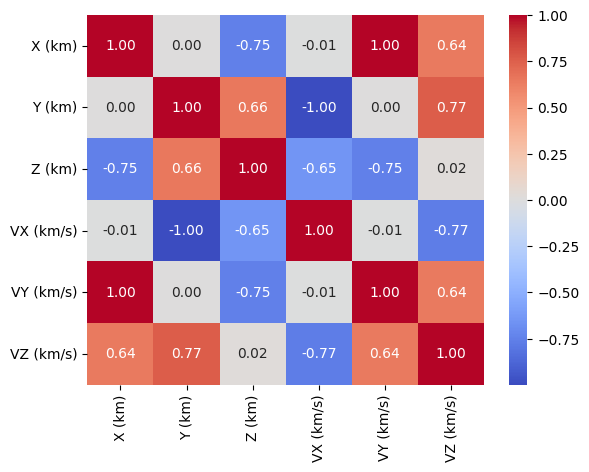

In [6]:
import seaborn as sns

X = df.drop(df.columns[0], axis=1)
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")

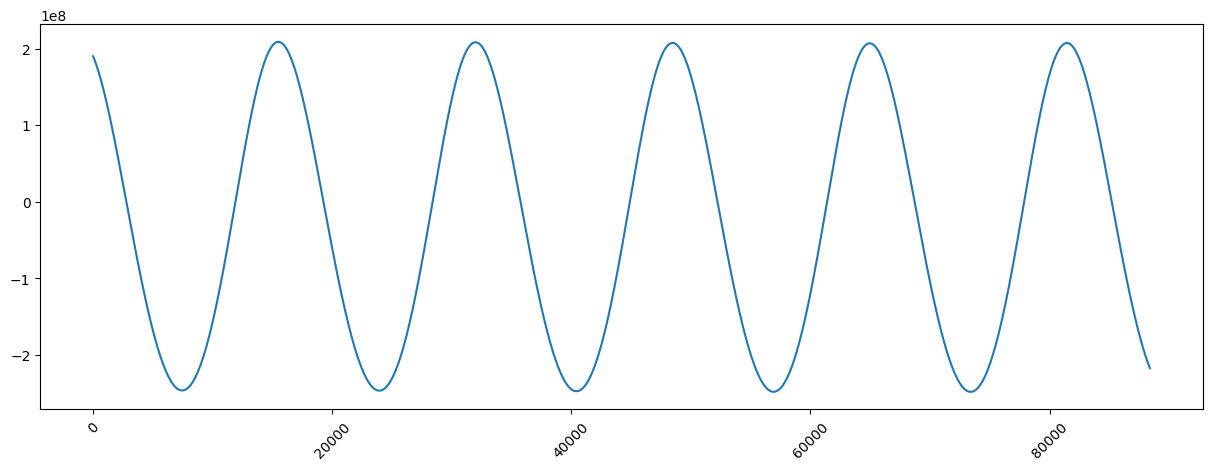

In [7]:
plt.figure(figsize = (15,5))
plt.plot(df['X (km)'])
plt.xticks(rotation = 45);


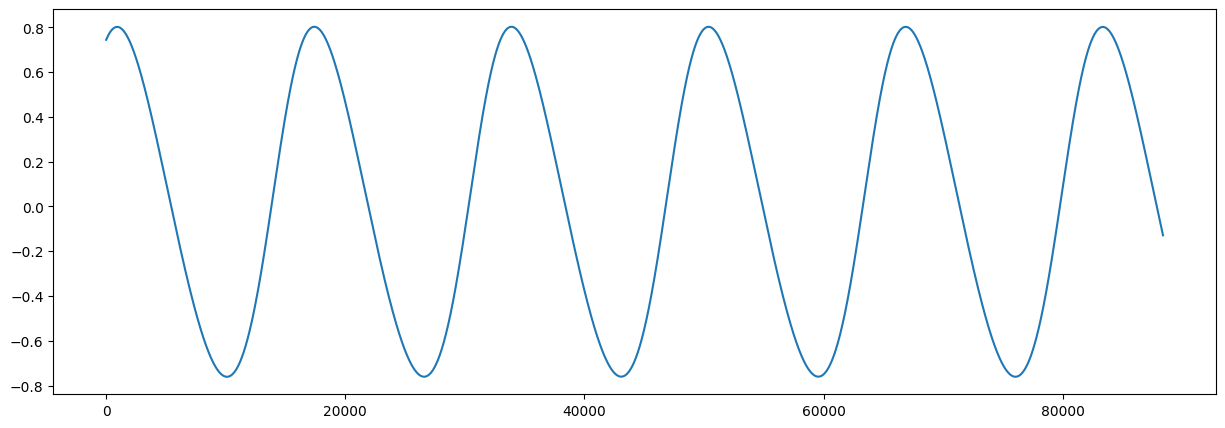

In [8]:
plt.figure(figsize = (15,5))
plt.plot(df['VZ (km/s)'])

In [13]:
sequence_length = 24
test_size = 0.2
validation_size = 0.2
batch_size = 32
epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
df_scaled


,X (km),Y (km),Z (km),VX (km/s),VY (km/s),VZ (km/s)
0,1.377712,0.449760,-0.744572,-0.519719,1.398182,1.291307
1,1.377481,0.450286,-0.744051,-0.520261,1.397895,1.291538
2,1.377249,0.450811,-0.743531,-0.520803,1.397608,1.291768
3,1.377017,0.451336,-0.743011,-0.521344,1.397321,1.291999
4,1.376784,0.451861,-0.742490,-0.521885,1.397033,1.292229
...,...,...,...,...,...,...
88388,-1.188324,0.597670,1.297854,-0.567331,-1.134673,-0.291865
88389,-1.188574,0.597246,1.297765,-0.566941,-1.134899,-0.292307
88390,-1.188824,0.596823,1.297676,-0.566551,-1.135124,-0.292749
88391,-1.189074,0.596399,1.297586,-0.566162,-1.135349,-0.293191


In [14]:
class SequenceDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        X = self.data.iloc[idx:idx+self.sequence_length].values
        y = self.data.iloc[idx+self.sequence_length].values
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


def train_evaluate_model(df_scaled):
    train_data, test_data = train_test_split(df_scaled, test_size=test_size, shuffle=False)
    train_data, val_data = train_test_split(train_data, test_size=validation_size, shuffle=False)

    train_dataset = SequenceDataset(train_data, sequence_length)
    val_dataset = SequenceDataset(val_data, sequence_length)
    test_dataset = SequenceDataset(test_data, sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = df_scaled.shape[1]
    hidden_size = 50
    output_size = df_scaled.shape[1]
    model = LSTMModel(input_size, hidden_size, output_size).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Boucle d'entraînement
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        print(f'Époque {epoch+1}/{epochs}, Perte Entraînement: {train_loss:.4f}, Perte Validation: {val_loss:.4f}')

    # Évaluation
    model.eval()
    test_loss = 0
    predictions = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            test_loss += criterion(outputs, y_batch).item()
            predictions.append(outputs.cpu().numpy())
    test_loss /= len(test_loader)
    predictions = np.concatenate(predictions)
    predictions_real = scaler.inverse_transform(predictions)
    y_test_real = scaler.inverse_transform(np.concatenate([y_batch.cpu().numpy() for _, y_batch in test_loader]))

    print(f'Perte Test: {test_loss:.4f}')
    for i in range(5):
        print(f'Prédit: {predictions_real[i]}, Réel: {y_test_real[i]}')

In [15]:
train_evaluate_model(df_scaled)

Époque 1/10, Perte Entraînement: 0.0129, Perte Validation: 0.0000
Époque 2/10, Perte Entraînement: 0.0001, Perte Validation: 0.0003
Époque 3/10, Perte Entraînement: 0.0001, Perte Validation: 0.0000
Époque 4/10, Perte Entraînement: 0.0001, Perte Validation: 0.0000
Époque 5/10, Perte Entraînement: 0.0001, Perte Validation: 0.0001
Époque 6/10, Perte Entraînement: 0.0001, Perte Validation: 0.0000
Époque 7/10, Perte Entraînement: 0.0001, Perte Validation: 0.0000
Époque 8/10, Perte Entraînement: 0.0000, Perte Validation: 0.0000
Époque 9/10, Perte Entraînement: 0.0000, Perte Validation: 0.0000
Époque 10/10, Perte Entraînement: 0.0000, Perte Validation: 0.0000
Perte Test: 0.0001
Prédit: [-1.5748048e+08  1.9007149e+08  7.8208245e+06 -1.7707922e+01
 -1.3404327e+01  1.5286368e-01], Réel: [-1.5668256e+08  1.9106176e+08  7.8489880e+06 -1.7885204e+01
 -1.3232967e+01  1.6181880e-01]
Prédit: [-1.57544912e+08  1.90023152e+08  7.82139000e+06 -1.77028770e+01
 -1.34104185e+01  1.52612552e-01], Réel: [-1.5

In [24]:
train_data, test_data = train_test_split(df_scaled, test_size=test_size, shuffle=False)
train_dataset = SequenceDataset(train_data, sequence_length)
len(train_dataset)
x,y= train_dataset[0]
x.shape

torch.Size([24, 6])